# Phase-resolved turbulent dissipation

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
from scipy import optimize
from scipy.signal import detrend
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as tck
from roxsi_pyfuns.plotting import multiple_formatter
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import stats as rps
from roxsi_pyfuns import turbulence as rpt
from roxsi_pyfuns import plotting as rppl

# Paths
# rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
rootdir = r'/home/malila/ROXSI/Asilomar2022/SmallScaleArray/'
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')
figdir = os.path.join(vec_root, 'img')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_1m.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))


## 24-h test case. 
Use 2022-07-13 01:00 -- 2022-07-14 01:00, which had the largest tidal range of the experiment as well as relatively stationary $H_\mathrm{s} \approx 1.3$ m and $T\mathrm{p} \approx 9$ s. 

List of processing steps:

1. Identify individual waves from zero crossings of 20-min. Vector surface elevation burst (linear $\kappa_\mathrm{rms}$ transform)​
    - **Check 1**: Only include waves with zero-crossing period longer than 8 sec:​ $T_\mathrm{w} > 8$ sec​
    - Interpolate wave elevation and velocities (16 Hz) to 160-point $0-2 \pi$ phase axis​
    - Sub-divide phase axis to 8 sub-phases, each with 20 interpolated data points​
2. For each sub-phase, estimate frequency spectrum from interpolated vertical velocity $w$​
    - Convert $f$-spectrum to $k$-spectrum using Taylor's hypothesis with advection speed $U$ defined as the average sub-phase horizontal velocity magnitude (both $u$ and $v$ components)
    - **Check 2**: $U / \mathrm{std}(U)$ must be more than 1 (George et al., 1994; Eq. (6)):​ $U / \mathrm{std}(U)$ > 1​
3. Estimate the dissipation rate $\epsilon$ from (noisy) single $k$-spectrum to get an estimate of the eddy turnover time scale defined as $(l^2 / \epsilon)^{1/3}$, where $l$ is the length scale corresponding to the lowest wavenumber of the best inertial subrange fit​
    - **Check 3**: Eddy turnover time scale must be much larger than advection time scale $(l / U)$: $\tau_\mathrm{eddy} / \tau_\mathrm{adv} > 5$​
4. If first 3 checks are passed, the $k$-spectrum is estimated again, this time interpolated to a predefined 30-point linear $k$-axis ranging from 0.05 m (max. $k$) to 0.5 m (min. $k$). No extrapolation is done beyond pre-defined $k$ range. ​
5. The interpolated spectrum is saved to one of 4 lists corresponding to ranges of $U$:​
    - bin1: ($U$ < 0.15 m/s)
    - bin2: (0.15 < $U$ < 0.3 m/s)
    - bin3: (0.3 < $U$ < 0.45 m/s)
    - bin4: ($U$ > 0.45 m/s)​
6. The interpolated spectra in each $U$ range are ensemble-averaged to produce a single mean spectrum per sub-phase.​
    - **Check 4**: To be included in the mean spectrum, each $k$-band can have max. 20% missing values (NaN). Spectral elements with more NaNs in a given $k$-band are assigned NaN​
7. For each sub-phase and each $U$ range, estimate dissipation rate from ensemble-average spectrum using a linear fit to log-transformed spectrum and wavenumbers. ​
    - Make the fit for all possible $k$-ranges longer than half of the length of the full $k$ axis.​
    - **Check 5**: If the fit has an $\mathrm{R}^2$ score higher than 0.9, save the estimated dissipation rate to a list: $\mathrm{R}^2 > 0.9$​
    - The final dissipation rate for the current sub-phase and $U$ range is the one corresponding to the highest $\mathrm{R}^2$.​
8. When using 4 distinct $U$ ranges, each 20-min burst can give 0--4 different dissipation rate estimates per sub-phase, depending on how many of the spectra pass all the checks outlined above.


In [49]:
# Serial numbers and corresponding mooring IDs
mids = ['C2', 'C3', 'C4']
sers = ['17212', '17219', '17371']
fs = 16 # Sampling freq
# Define number of sub-segments per wave cycle (should be even)
ncyc = 8
# Minimum R^2 threshold for inertial subrange fits
r2_thresh = 0.9
# Minimum ratio of eddy timescale over advection timescale
eddy_adv_ratio = 5
# Sample period
# t0 = pd.Timestamp('2022-07-14 14:00:00')
t0 = pd.Timestamp('2022-07-13 01:00:00')
# t0 = pd.Timestamp('2022-07-19 06:00:00')
t1 = t0 + pd.Timedelta(hours=6)
spd = 60 * 60 * 24 # Seconds per day
# Define expected headings in PCA coordinates for C2 & C3
heading_exp = {'C2': -125, 'C3': -90, 'C4': None}

# Lists for hourly burst averages
wave_int_e = {'{}'.format(m): [] for m in mids} # Interpolated wave elevations
wave_int_u = {'{}'.format(m): [] for m in mids} # Interpolated wave u velocities
wave_int_v = {'{}'.format(m): [] for m in mids} # Interpolated wave v velocities
wave_int_w = {'{}'.format(m): [] for m in mids} # Interpolated wave w velocities
# Dissipation rates per wave-cycle subsegment
diss_subsegs = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
# diss_subseg = {'{}'.format(m): diss_subsegs for m in mids}
diss_subseg = {'{}'.format(m): {} for m in mids}
for mid in mids:
    diss_subseg[mid] = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
# Mean horizontal velocities U per wave-cycle subsegment
Us = {'q{}'.format(n): [] for n in range(1,ncyc+1)}
u_subseg =  {'{}'.format(m): Us for m in mids}

# Define number of bins to use for advection speed U (1-4)
nbins = 4
# Define type of fit to use for dissipation rate calculation
fit = 'curve'

# Test plot 1, k-spectra and -5/3 fits
plot1 = True
plot2 = False

# Iterate over C2, C3, C4 moorings
for mid, ser in zip(mids, sers):
    print('{} - {}'.format(mid, ser))
    # Read netcdf file, check if need to concatenate multiple days
    if ((t1.date() - t0.date()).total_seconds() / spd) > 0:
        # More than one day -> concatenate daily datasets
        drc = pd.date_range(t0.date(), t1.date(), freq='1D') # Range of dates
        dlc = [] # List for concatenating
        for d in drc:
            ncdir = os.path.join(vec_root, mid)
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(
                ser, str(d.strftime('%Y%m%d'))))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
            # Append to list
            dlc.append(dsv)
        # Concatenate daily datasets
        dsv = xr.concat(dlc, dim='time')
    else:
        # Only one day
        ncdir = os.path.join(vec_root, mid)
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
            str(t0.strftime('%Y%m%d'))))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))

    # Wave couter
    wcnt = 0
    # Iterate over bursts
    time_range = pd.date_range(t0, t1, freq='1H')
    for t0b in time_range:
        t1b = t0b + pd.Timedelta(hours=1)
        if t1b > t1:
            continue
        # print('{}-{}'.format(t0b, t1b.time()))
        # Select sample period
        seg = dsv.sel(time=slice(t0b, t1b))
        eta = seg.eta_lin_krms.copy().to_series() # Surface elevation

        # Convert velocities to cross-/alongshore
        # x vel, despiked
        uxd = seg.uxd.to_dataframe() # Convert to pandas
        uxd = uxd.interpolate(method='bfill').interpolate('ffill')
        uxd -= uxd.mean()
        # y vel, despiked
        uyd = seg.uyd.to_dataframe() # Convert to pandas
        uyd = uyd.interpolate(method='bfill').interpolate('ffill')
        uyd -= uyd.mean()
        # z vel, despiked
        uzd = seg.uzd.to_dataframe() # Convert to pandas
        uzd = uzd.interpolate(method='bfill').interpolate('ffill')
        uzd -= uzd.mean()
        # Rotate velocities to cross/alongshore & vertical using PCA
        ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                           uy=uyd.values.squeeze(), 
                                           uz=uzd.values.squeeze(),
                                           heading_exp=heading_exp[mid], 
                                           # print_msg=True,
                                           )

        # Estimate full w-spectrum (testing)
        wspec = rpws.spec_uvz(uw, fs=16)

        # Get zero-crossings, min. 4-sec waves
        zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=4*16)
        nwaves = len(Hw)
        # Compute H(1/3)
        Hws = np.sort(Hw) # Sorted wave heights
        H13 = np.mean(Hws[2*(nwaves//3):]) # Mean of highest 1/3 of waves
        # Define phase (x) axis to interpolate to
        n_phase = 160 # Number of points in phase axis
        min_period = 8 # Min. wave period (sec) to include

        # Lists for storing dataframes of spectral segments for merging
        # for different ranges of advection speed U
        dfsi_lists_1 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        dfsi_lists_2 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        dfsi_lists_3 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        dfsi_lists_4 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        # Interpolate eta, u_cs and w for each wave to wave phase (0-2*pi)
        for zi,zc0 in enumerate(zc[:-1]):
            # Only include waves with T > min_period sec
            Tw = (eta.index[zc[zi+1]] - eta.index[zc[zi]]).total_seconds()
            if Tw < min_period:
                continue
            # Also only include high waves
            Hwi = Hw[zi]
#             if Hwi < H13:
#                 continue
            # Wave surface elevation, u, v and w for current wave
            eta_wave = eta.iloc[zc0:zc[zi+1]]
            u_wave = ucs[zc0:zc[zi+1]]
            v_wave = uls[zc0:zc[zi+1]]
            w_wave = uw[zc0:zc[zi+1]]
            # Surface elevation interpolation
            df_e = rpzc.interpolate_phase(eta_wave.squeeze(), N=n_phase, 
                                          label='eta_int_{:04d}'.format(wcnt))
            wave_int_e[mid].append(df_e)
            # Cross-shore vel. interpolation
            df_u = rpzc.interpolate_phase(u_wave.squeeze(), N=n_phase, 
                                          label='u_int_{:04d}'.format(wcnt))
            wave_int_u[mid].append(df_u)
            # Long-shore vel. interpolation
            df_v = rpzc.interpolate_phase(v_wave.squeeze(), N=n_phase, 
                                          label='u_int_{:04d}'.format(wcnt))
            wave_int_v[mid].append(df_v)
            # Vertical vel. interpolation
            df_w = rpzc.interpolate_phase(w_wave.squeeze(), N=n_phase, 
                                          label='u_int_{:04d}'.format(wcnt))
            wave_int_w[mid].append(df_w)
            # Increase wave counter
            wcnt =+ 1

            # Estimate spectra for 1/ncyc wave cycles
            nsub = n_phase // ncyc
            # Frequencies
            n_freqs = int(np.floor(nsub / 2 )) # No. of frequency bands
            # Wavenumbers to interpolate spectrum to
            n_int = n_freqs * 3 # Number of wavenumbers to interpolate to
            kmin = (2*np.pi) / 0.5 # Min. interpolation wavenumber
            kmax = (2*np.pi) / 0.05 # Max. interpolation wavenumber
            ki = np.linspace(kmin, kmax, n_int) # Interp. target k's
            # Initialize dict to store spectral dataframes for different ranges
            # of the advection velocity U
            dfsi = {} # k-spec dataframes
            for nb in range(1, nbins+1):
                dfsi['{}'.format(nb)] = {}
            for i in range(ncyc):
                # Get short-segment velocities
                useg = df_u.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                vseg = df_v.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                wseg = df_w.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                # Compute mean current and check that U >> dU for segment
                U = np.sqrt(np.mean(useg)**2 + np.mean(vseg)**2).item() # Mean orb. vel. mag.
                umag = np.sqrt(useg**2 + vseg**2) # Orb. vel. magnitude, not mean
                dU = np.std(umag) # Variability in umag (following George et al., 1994)
                # Check U/dU ratio
                if (U / dU) < 1:
                    # U vs. dU ratio (Eq (6) of George et al., 1994) too small
                    # Use U / dU = 1 as threshold following Rosman & Gerbi (2017), Fig. 9
                    continue
                # Check that the turnover timescale of the eddies is much longer 
                # than the time for advection of the eddies past the sensor.
                # First estimate k spectrum of w following George et al. (1994)
                k_spec = rpt.k_spec_wavephase(w=wseg, U=U)
                # Make (noisy) first estimate of dissipation rate from single
                # spectrum for eddy time scale
                rs_list = [] # R^2 values of fits
                eps_list = [] # Dissipation rate estimates from fits
                si_list = [] # Start indices of fits (to get lowest k of best fit)
                sis = np.arange(1, n_freqs//2) # Start indices of -5/3 fit
                eis = -np.arange(1, n_freqs//2)[::-1] # End indices of fit
                # Iterate over different k ranges and fit inertial subrange
                for si in sis:
                    for ei in eis:
                        N = len(k_spec.index[si:ei])
                        if N < n_freqs // 2:
                            # Don't try to fit to less than half of 
                            # available points
                            continue
                        # No NaNs allowed
                        if np.any(np.isnan(k_spec.values.squeeze()[si:ei])):
                            continue
                        if np.any(k_spec.values.squeeze()[si:ei] < 0):
                            print('Negative spectrum')
                        if np.any(ki[si:ei] < 0):
                            print('Negative k')
                        # Get diss. rate and R^2 of inertial subrange fit to 
                        # spectrum segment
                        epsilon, r_squared, coeff = rpt.dissipation_rate(
                            k=k_spec.index[si:ei], spec=k_spec.values.squeeze()[si:ei], 
                            fit=fit)
                        # Save R^2 and epsilon to dict
                        rs_list.append(r_squared)
                        eps_list.append(epsilon)
                        si_list.append(si)
                # Find best fit from R^2 (highest) and fit length (longest)
                if len(rs_list) == 0:
                    # No fits were made (too many NaNs)
                    continue
                # Get index of max. R^2
                max_rsq_ind = np.argmax(rs_list)
                # Use dissipation rate estimate with highest R^2 value
                eps_est = eps_list[max_rsq_ind]
                # Use lowest k included in the best fit
                sim = si_list[max_rsq_ind]
                l = 2*np.pi / k_spec.index[sim]
                # Compute eddy time scale (Eq. 6.11 of Pope, pg. 187)
                t_eddy = (l**2 / eps_est)**(1/3)
                # Compute advection time scale
                t_adv = l / U
                # Check t_eddy vs. t_adv criterion, only save spectrum
                # for later ensemble averaging if ratio high enough
                if (t_eddy / t_adv) < eddy_adv_ratio:
                    # Ratio too low -> don't save spectrum
                    continue
                # Estimate new k spectrum with longer k axis and save to dicts
                # for various U bins based on requested number of U bins.
                k_spec = rpt.k_spec_wavephase(w=wseg, U=U, k_int=ki)
                if nbins == 1:
                    dfsi['1']['q{}'.format(i+1)] = k_spec
                elif nbins == 2:
                    if U < 0.50:
                        dfsi['1']['q{}'.format(i+1)] = k_spec
                    elif U >= 0.5: #and U < 0.75:
                        dfsi['2']['q{}'.format(i+1)] = k_spec
                elif nbins == 3:
                    if U < 0.25:
                        dfsi['1']['q{}'.format(i+1)] = k_spec
                    elif U >= 0.25 and U < 0.5:
                        dfsi['2']['q{}'.format(i+1)] = k_spec
                    elif U >= 0.5:
                        dfsi['3']['q{}'.format(i+1)] = k_spec
                elif nbins == 4:
                    if U < 0.15:
                        dfsi['1']['q{}'.format(i+1)] = k_spec
                    elif U >= 0.15 and U < 0.3:
                        dfsi['2']['q{}'.format(i+1)] = k_spec
                    elif U >= 0.3 and U < 0.45:
                        dfsi['3']['q{}'.format(i+1)] = k_spec
                    elif U >= 0.45:
                        dfsi['4']['q{}'.format(i+1)] = k_spec
                # Save U
                u_subseg[mid]['q{}'.format(i+1)].append(U)

            # Save dataframes to list for merging
            for n in range(1, ncyc+1):
                if 'q{}'.format(n) in dfsi['1'].keys():
                    dfsi_lists_1['dfs{}'.format(n)].append(
                        dfsi['1']['q{}'.format(n)])
                if nbins > 1:
                    if 'q{}'.format(n) in dfsi['2'].keys():
                        dfsi_lists_2['dfs{}'.format(n)].append(
                            dfsi['2']['q{}'.format(n)])
                if nbins > 2:
                    if 'q{}'.format(n) in dfsi['3'].keys():
                        dfsi_lists_3['dfs{}'.format(n)].append(
                            dfsi['3']['q{}'.format(n)])
                if nbins > 3:
                    if 'q{}'.format(n) in dfsi['4'].keys():
                        dfsi_lists_4['dfs{}'.format(n)].append(
                            dfsi['4']['q{}'.format(n)])

        # Concatenate spectral dataframes
        dfs = {} # Dataframes to concatenate
        for nb in range(1, nbins+1):
            dfs['{}'.format(nb)] = {}
        for n in range(1, ncyc+1):
            if len(dfsi_lists_1['dfs{}'.format(n)]) > 0:
                dfs['1']['q{}'.format(n)] = pd.concat(
                    dfsi_lists_1['dfs{}'.format(n)], axis=1)
            if nbins > 1:
                if len(dfsi_lists_2['dfs{}'.format(n)]) > 0:
                    dfs['2']['q{}'.format(n)] = pd.concat(
                        dfsi_lists_2['dfs{}'.format(n)], axis=1)
            if nbins > 2:
                if len(dfsi_lists_3['dfs{}'.format(n)]) > 0:
                    dfs['3']['q{}'.format(n)] = pd.concat(
                        dfsi_lists_3['dfs{}'.format(n)], axis=1)
            if nbins > 3:
                if len(dfsi_lists_4['dfs{}'.format(n)]) > 0:
                    dfs['4']['q{}'.format(n)] = pd.concat(
                        dfsi_lists_4['dfs{}'.format(n)], axis=1)

        # Dicts to store curve fit coeff.
        rsqs = {} # R^2 value for best fit
        coeffs = {} # Fit coefficient for best fit
        sid = {} # Optimal start index for fit
        eid = {} # Optimal end index for fit
        diss_rate = {}
        # Define figure filename
        figdir_spec = os.path.join(figdir, 'turb_spec')
        if not os.path.isdir(figdir_spec):
            os.mkdir(figdir_spec)
        fn_fig = os.path.join(figdir_spec, 'kspec_{}_{}_ubins_{}_fit_{}.png'.format(
            mid, t0b.strftime('%Y%m%d_%H%M'), nbins, fit))
        # Initialize test plot 1, k-spectra and -5/3 fits
        if plot1 and not os.path.isfile(fn_fig):
            # Define fit function
            def fun(x, c):
                """
                Standard curve fit to inertial subrange k^{-5/3}.
                """
                return c * x ** (-5/3)
            nrows = ncyc//4
            fig, axes = plt.subplots(figsize=(7,2.5*nrows), 
                ncols=4, nrows=nrows, sharex=True, sharey=True)
            csu = ['C0', 'C1', 'C2', 'C3'] # Colors for plot
        # Iterate over sub-sections
        for n in range(1, ncyc+1):
            # Iterate over U ranges defined by nbins
            for ui in range(1, nbins+1):
                if not 'q{}'.format(n) in dfs[str(ui)].keys():
                    continue
                dfi = dfs[str(ui)]['q{}'.format(n)].copy()
                # Average spectra for wavenumbers with no more than maxnan % of
                # NaN values
                maxnan = 0.2 # Max. allowed fraction of NaNs per wavenumber
                ps_mean = dfi.where(
                    (dfi.isnull().sum(axis=1)/len(dfi.columns))<maxnan).mean(
                        axis=1).values
                # Lists to store curve fit coeff.
                rsqs_i = [] # R^2 value for best fit
                coeffs_i = [] # R^2 value for best fit
                sid_i = [] # Optimal start index for fit
                eid_i = [] # Optimal end index for fit
                npts = [] # Number of points to fit
                diss_i = [] # Dissipation rates
                # Iterate over different start/end freq. indices for fit
                # Disregard first (0-th) wavenumber
                sis = np.arange(1, n_int//2)
                eis = -np.arange(1, n_int//2)[::-1]
                for si in sis:
                    for ei in eis:
                        N = len(ki[si:ei])
                        # if N < 10 * 8//ncyc:
                        if N < n_int // 2:
                            # Don't try to fit to less than half of 
                            # available points
                            continue
                        # No NaNs allowed
                        if np.any(np.isnan(ps_mean[si:ei])):
                            continue

                        # Get diss. rate and R^2 of inertial subrange fit to 
                        # spectrum segment
                        epsilon, r_squared, coeff = rpt.dissipation_rate(
                            k=ki[si:ei], spec=ps_mean[si:ei], fit=fit)
                        # Save to dict if R^2 high enough
                        if r_squared >= r2_thresh:
                            rsqs_i.append(r_squared)
                            coeffs_i.append(coeff)
                            sid_i.append(si)
                            eid_i.append(ei)
                            npts.append(N)
                            diss_i.append(epsilon)
                # Find best fit from R^2 (highest) and fit length (longest)
                if len(rsqs_i) == 0:
                    # No fits were made (too many NaNs)
                    continue
                max_rsq_ind = np.argmax(rsqs_i)
                # Save parameters corresponding to max R^2
                rsqs['q{}'.format(n)] = rsqs_i[max_rsq_ind]
                coeffs['q{}'.format(n)] = coeffs_i[max_rsq_ind]
                sid['q{}'.format(n)] = sid_i[max_rsq_ind]
                eid['q{}'.format(n)] = eid_i[max_rsq_ind]
                diss_rate['q{}'.format(n)] = diss_i[max_rsq_ind]
                # Also append to ensemble-avg list
                diss_subseg[mid]['{}/{}'.format(n, ncyc)].append(
                    diss_i[max_rsq_ind])
                # Plot spectra and -5/3 fits for each wave-phase 
                # subsegment?
                if plot1 and not os.path.isfile(fn_fig):
                    # Check is current segment has data to plot
                    if 'q{}'.format(n) in sid.keys():
                        si = sid_i[max_rsq_ind]
                        ei = eid_i[max_rsq_ind]
                        rsq = rsqs_i[max_rsq_ind]
                        cf = coeffs_i[max_rsq_ind]
                        diss = diss_i[max_rsq_ind]
                        ax = axes.flat[n-1]
                        dfi.iloc[1:].mean(axis=1).plot(
                            ax=ax, c=csu[ui-1], label='ubin {}'.format(ui))
                        ax.loglog(ki[si:ei], fun(ki[si:ei], cf), 
                            linestyle='--', color='k')
                        if nbins == 1:
                            # Annotate R^2
                            ax.annotate(r'$R^2$='+'{:.2f}'.format(rsq), xy=(0.05, 0.03), 
                                        xycoords='axes fraction', fontsize=9)
                            # Annotate dissipation rate
                            ax.annotate(r'$\epsilon$='+'{:.2E}'.format(diss), 
                                        xy=(0.05, 0.11), xycoords='axes fraction', 
                                        fontsize=9)

        if plot1 and not os.path.isfile(fn_fig):
            # Labels & ticks
            for ax in axes[1,:]:
                ax.set_xlabel(r'$k$ [rad/m]')
                ax.set_xlim([10, 200])
                ax.set_ylim([1e-7, 1e-3])
                ax.set_xticks([10, 100])
                # ax.get_xaxis().get_major_formatter().labelOnlyBase = False
                ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
            for ax in axes[:,0]:
                ax.set_ylabel(r'$\phi(k)$ [$(\mathrm{m}^2\mathrm{s}^{-2})$/(rad/m)]')
            # Set log-log axes
            for na, ax in enumerate(axes.flat):
                if ax.lines:
                    # Legend if not empty plot (to avoid warnings)
                    ax.legend(fontsize=8)

                ax.set_xscale('log')
                ax.set_yscale('log')
                # Annotate sub segment number
                ax.annotate('{}/{}'.format(na+1, ncyc), xy=(0.03, 0.88), 
                            xycoords='axes fraction', fontsize=14)
            plt.suptitle('{} {}, # of U-bins: {}, fit: {}'.format(
                mid, t0b, nbins, fit))
            plt.tight_layout()
            # plt.show()
            plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
            plt.close()

# Concatenate interpolated wave variables dataframes
df_ei = {'{}'.format(m): [] for m in mids}
df_ui = {'{}'.format(m): [] for m in mids}
df_vi = {'{}'.format(m): [] for m in mids}
df_wi = {'{}'.format(m): [] for m in mids}
print('Concatenating dataframes ...')
for mid in mids:
    df_ei[mid] = pd.concat(wave_int_e[mid], axis=1) # Interp. surface elevation
    df_ui[mid] = pd.concat(wave_int_u[mid], axis=1) # Interp. surface elevation
    df_vi[mid] = pd.concat(wave_int_v[mid], axis=1) # Interp. surface elevation
    df_wi[mid] = pd.concat(wave_int_w[mid], axis=1) # Interp. vertical vel.

# Average wave phase vs. dissipation rate plot
cs = ['k', 'b', 'r']
lss = ['-', '--', ':']
if plot2:
    fig, axes = plt.subplots(figsize=(5,6), nrows=3, sharex=True)
    for ax in axes:
        # Mark subsections
        for nc in np.arange(ncyc)[::2]:
            ax.axvspan(nc*2*np.pi/ncyc, (nc+1)*2*np.pi/ncyc, color='gray', 
                       alpha=0.25)
    # Iterate over moorings
    for m, mid in enumerate(mids):
        # Ensemble-avg eta on top, with +/- 1*std errorbars
        axes[0].errorbar(df_ei[mid].index, df_ei[mid].mean(axis=1), 
            ls=lss[m], yerr=df_ei[mid].std(axis=1), c=cs[m], capsize=3, 
            errorevery=((m+10),20), label=mid)
        # Ensemble-avg w in middle, with +/- 1*std errorbars
        axes[1].errorbar(df_wi[mid].index, df_wi[mid].mean(axis=1), 
            ls=lss[m], yerr=df_wi[mid].std(axis=1), c=cs[m], capsize=3, 
            errorevery=((m+10),20))
        # Dissipation rates per wave-phase subsection
        for n in range(1, ncyc+1):
            # All epsilon values for current phase subsection
            eps = diss_subseg[mid]['{}/{}'.format(n, ncyc)]
            # Centered x-locations
            positions = [n*2*np.pi/ncyc - np.pi/(ncyc) - (np.pi/16)*(2-(m+1))]
            # Box plot of epsilon range
            # axes[2].boxplot(x=eps, positions=positions, color=cs[m])
            rppl.box_plot(ax=axes[2], data=eps, positions=positions, 
                edge_color=cs[m], fill_color='white', showfliers=False)

    # Set x axis labels as multiples of pi
    for ax in axes:
        ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # Grid
        ax.grid(alpha=0.5)

    # Axis labels
    axes[0].set_title('{}-{}'.format(t0, t1))
    axes[0].set_ylabel(r'$\langle \zeta \rangle$ [m]')
    axes[1].set_ylabel(r'$\langle w \rangle$ [m/s]')
    axes[2].set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')

    axes[2].set_title('# of U-bins: {}'.format(nbins))

    # Legend on top row
    handles, labels = axes[0].get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    axes[0].legend(handles, labels, loc='upper right')

    # Set dissipation rate y scale to log
    axes[2].set_yscale('log')
    axes[2].set_ylim([1e-6, 1e-2])

    plt.tight_layout()
    plt.show()
    # plt.close()


C2 - 17212
C3 - 17219
C4 - 17371
Concatenating dataframes ...


Make test plot comparing standard curve fit to linear fit to log transform of spectrum.

rsc: 0.9084673028453921, rsl: 0.9557987961719568


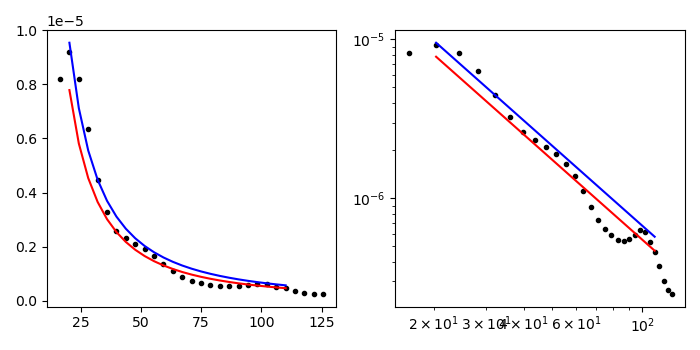

In [3]:
# Test plot curve fit vs. linear fit to log transform

from scipy.optimize import curve_fit

# Test spectrum and wavenumbers
k = dfi.iloc[1:].mean(axis=1).index
s = dfi.iloc[1:].mean(axis=1).values

# Test start/end indices
si = 1
ei = -4
# Curve fit
ec, rsc, cfc = rpt.dissipation_rate(k=k[si:ei], spec=s[si:ei], fit='curve')
# Linear fit
el, rsl, cfl = rpt.dissipation_rate(k=k[si:ei], spec=s[si:ei], fit='linear')
print('rsc: {}, rsl: {}'.format(rsc, rsl))

# Plot, standard scale on left, loglog on right
fig, axes = plt.subplots(figsize=(7,3.5), ncols=2)
# Plot spectrum in black dots
axes[0].plot(k, s, linestyle='none', marker='.', c='k')
# Curve fit in red
axes[0].plot(k[si:ei], fun(k[si:ei], cfc), linestyle='-', color='b')
# Linear fit in blue
axes[0].plot(k[si:ei], fun(k[si:ei], cfl), linestyle='-', color='r')
# Loglog on right
axes[1].loglog(k, s, linestyle='none', marker='.', c='k')
axes[1].loglog(k[si:ei], fun(k[si:ei], cfc), linestyle='-', color='b')
axes[1].loglog(k[si:ei], fun(k[si:ei], cfl), linestyle='-', color='r')

plt.tight_layout()
plt.show()
# plt.close()
